CS 4701 AI Prac




Names: Quinn Liu, Olivia Lu, Eli Zhang

Netids: qjl3, ol48, ekz5

Don't forget to share your newly copied notebook with your partner!


# Overview

---
todo


# Task and dataset

---

1. Obtain the data from Kaggle at https://www.kaggle.com/google/tinyquickdraw.
  This only needs to be done once. 
2. Unzip the data. Put it into your google drive, and mount it on colab as per below:

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d google/tinyquickdraw

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir)

In [ ]:
! mkdir /content/drive/My\ Drive/CS\ 4701\ Prac/data
! unzip /content/drive/My\ Drive/CS\ 4701\ Prac/tinyquickdraw.zip -d /content/drive/My\ Drive/CS\ 4701\ Prac/data

mkdir: cannot create directory ‘/content/drive/My Drive/CS 4701 Prac/data’: No such file or directory
unzip:  cannot find or open /content/drive/My Drive/CS 4701 Prac/tinyquickdraw.zip, /content/drive/My Drive/CS 4701 Prac/tinyquickdraw.zip.zip or /content/drive/My Drive/CS 4701 Prac/tinyquickdraw.zip.ZIP.


# Run this code every time to start: 

In [1]:
! pip install ndjson

In [2]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import ndjson
import gc
import PIL
from PIL import Image, ImageDraw, ImageFilter
import torch
from torch.utils.data import DataLoader, IterableDataset, Dataset
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, models, transforms    
import torchvision.transforms as transforms              # composable transforms
import json
import ndjson
from tqdm import trange
import tqdm.notebook as tq
from datetime import datetime
import pickle



drive.mount('/content/drive', force_remount=True)

data_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "data", "quickdraw_simplified")
flattened_data_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "data")
# dataset = np.load(data_path, encoding='latin1', allow_pickle=True)


Mounted at /content/drive


In [3]:
paths = os.listdir(data_path)
classes = {}
for i, f in enumerate(paths):
    classes[f[:-7]] = i

print(classes)

{'The Eiffel Tower': 0, 'The Mona Lisa': 1, 'angel': 2, 'ant': 3, 'apple': 4, 'banana': 5, 'bathtub': 6, 'beach': 7, 'beard': 8, 'bee': 9, 'binoculars': 10, 'bird': 11, 'book': 12, 'bowtie': 13, 'brain': 14, 'broccoli': 15, 'bucket': 16, 'bulldozer': 17, 'butterfly': 18, 'cake': 19, 'camel': 20, 'camera': 21, 'ceiling fan': 22, 'cello': 23, 'clock': 24, 'compass': 25, 'computer': 26, 'cow': 27, 'dog': 28, 'dolphin': 29, 'dragon': 30, 'drums': 31, 'ear': 32, 'elbow': 33, 'elephant': 34, 'eye': 35, 'eyeglasses': 36, 'face': 37, 'fireplace': 38, 'flamingo': 39, 'flip flops': 40, 'foot': 41, 'fork': 42, 'garden': 43, 'giraffe': 44, 'grapes': 45, 'hand': 46, 'harp': 47, 'hat': 48, 'headphones': 49, 'hedgehog': 50, 'helicopter': 51, 'hospital': 52, 'hot air balloon': 53, 'hot dog': 54, 'house plant': 55, 'house': 56, 'ice cream': 57, 'kangaroo': 58, 'key': 59, 'keyboard': 60, 'lantern': 61, 'leg': 62, 'light bulb': 63, 'lighthouse': 64, 'lion': 65, 'lobster': 66, 'lollipop': 67, 'mailbox': 6

#Helper Methods and Preprocessing



In [ ]:
flatten = lambda t: [item for sublist in t for item in sublist]

def draw_it(raw_strokes):
    image = Image.new("P", (255,255), color=255)
    image_draw = ImageDraw.Draw(image)

    # for stroke in eval(raw_strokes):
    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=3)
    return np.array(image)


***DO !! NOT!! RUN EVERY TIME ;;-;;***

In [ ]:
ct = 0
paths = os.listdir(data_path)
## Clearing files, uncomment if you want files to be deleted before running
if os.path.exists(flattened_data_path + "/all_data.p"):
    print("Clearing pre-existing data files to start from scratch...")
    os.remove(flattened_data_path + "/all_data.p")
if os.path.exists(flattened_data_path + "/all_labels.p"):
    os.remove(flattened_data_path + "/all_labels.p")

for i, f in enumerate(paths):
    print("Progress:", i, "/", len(paths))
    with open(data_path + "/" + f) as json_file:
        train_data = [] # Flattened training data
        label_data = [] # Flattened label data
        pickle_data_amount = 0
        d = ndjson.load(json_file)
        label = f[:-7]
        for entry in d:
            if ct % 40 == 0:  ## only take 1/30 of data set for disk space concerns
                full_image = draw_it(entry["drawing"])

                train_data.append(full_image)
                label_data.append(label)

            ## If you want to display the images, uncomment below
            # plt.imshow(draw_it(entry["drawing"]), cmap="gray")
            # plt.show()

            ct += 1
            pickle_data_amount += 1
            if ct % 10000 == 0:
                print(ct)
            if pickle_data_amount > 50000:
                print("Appending some data for label {}...".format(label))
                pickle.dump(train_data, open(flattened_data_path + "/all_data.p", "ab"))
                pickle.dump(label_data, open(flattened_data_path + "/all_labels.p", "ab"))
                train_data = []
                label_data = []
                pickle_data_amount = 0
        pickle.dump(train_data, open(flattened_data_path + "/all_data.p", "ab"))
        pickle.dump(label_data, open(flattened_data_path + "/all_labels.p", "ab"))
        print("Done appending data for label {}...".format(label))
print("Done flattening all data and labels!")


Clearing pre-existing data files to start from scratch...
Progress: 0 / 140


KeyboardInterrupt: ignored

In [ ]:
## Updates all the drive contents (but you need to remount)
# drive.flush_and_unmount()

### **RUN TO SPLIT INTO TRAIN/VALID/TEST**

In [ ]:
# all_data = np.array(pickle.load( open( flattened_data_path + "/all_data.p", "rb" ) ))
# all_labels = np.array(pickle.load( open( flattened_data_path + "/all_labels.p", "rb" ) ))
# n = len(all_data)

def splitter(n, data, labels):
  train_size = int(np.floor(n*0.8))
  
  valid_size = int(np.floor(n*0.2))
  # test_size = int(np.floor(n*0.15))
  print("SIZES:")
  print(n, train_size, valid_size)
  rand = np.random.permutation(n)
  train_idx = rand[0:train_size]
  valid_idx = rand[train_size:train_size+valid_size]
  # test_idx = rand[train_size+valid_size:train_size+valid_size+test_size]

  train_data = data[train_idx]
  valid_data = data[valid_idx]
  # test_data = data[test_idx]

  train_labels = labels[train_idx]
  valid_labels = labels[valid_idx]
  # test_labels = labels[test_idx]
  return train_data, train_labels, valid_data, valid_labels


In [ ]:
packed_data = []
packed_labels = [] 
packed_images_file = open(flattened_data_path + "/255/test_data.p", 'rb')
packed_labels_file= open(flattened_data_path + "/255/test_label.p", 'rb')
for i in range(len(classes)):
    packed_data.append(pickle.load(packed_images_file))
    packed_labels.append(pickle.load(packed_labels_file))
fl_packed_labels = np.array(flatten(packed_labels))
fl_packed_data = np.array(flatten(packed_data))

In [ ]:
train_cnn, train_labels_cnn, valid_cnn, valid_labels_cnn = splitter(len(fl_packed_labels), fl_packed_data, fl_packed_labels)

In [ ]:
# # train_data_small = []
# # train_labels_small = [] 
# # small_images_file = open(flattened_data_path + "/255/test_data.p", 'rb')
# # small_labels_file= open(flattened_data_path + "/255/test_label.p", 'rb')
# val_data_small = []
# val_labels_small = [] 
# small_v_images_file = open(flattened_data_path + "/255/valid_data.p", 'rb')
# small_v_labels_file= open(flattened_data_path + "/255/valid_label.p", 'rb')

# # for i in range(len(classes)):
#   # train_data_small.append(pickle.load(small_images_file))
#   # train_labels_small.append(pickle.load(small_labels_file))
#   # val_data_small.append(pickle.load(small_v_images_file))
#   # val_labels_small.append(pickle.load(small_v_labels_file))

# # train_cnn_small = np.array(flatten(train_data_small))
# # train_labels_cnn_small = np.array(flatten(train_labels_small))
# valid_cnn_small = np.array(flatten(val_data_small))
# valid_labels_cnn_small = np.array(flatten(val_labels_small))

In [ ]:
#check to see all the classes
seen = np.zeros(140)
for i in fl_packed_labels:
  seen[classes[i]] = 1
print(sum(seen))

# DEFINING NEURAL NET

In [4]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

True


In [5]:
class SketchDataSetStream(IterableDataset):
    def __init__(self, image_data_path, image_label_path, classes, transform=None):
        """
        Args:
            classes (list of strings): list of class names, same as names of
                subfolders under root_dir
                
            transform (callable, optional): Optional transform to be applied
                on a sample.
                
        """
        self.images = []
        self.labels = []
        self.classes = classes
        self.transform = transform
        self.image_stream = open(flattened_data_path + image_data_path, 'rb')
        self.label_stream = open(flattened_data_path + image_label_path, 'rb')

    def __iter__(self):
        self.image_stream.seek(0)
        self.label_stream.seek(0)
        return self

    def __next__(self):
        if not self.images:
            try:
                self.images = pickle.load(self.image_stream)
                self.labels = pickle.load(self.label_stream)
            except EOFError:
                raise StopIteration
        assert len(self.images) == len(self.labels)
        if not self.images:
            raise StopIteration
        image, label = self.images.pop(0), self.labels.pop(0)
        image = self.transform(image)
        label = torch.tensor([classes[label]], dtype=torch.long)
        return image, label

    def close(self):
        if self.image_stream:
            self.image_stream.close()
            self.image_stream = None
        if self.label_stream:
            self.label_stream.close()
            self.label_stream = None

In [6]:
class SketchDataSet(Dataset):
    def __init__(self, arr, labels, classes, transform=None):
        """
        Args:
            classes (list of strings): list of class names, same as names of
                subfolders under root_dir
                
            transform (callable, optional): Optional transform to be applied
                on a sample.
                
        """
        self.arr = arr
        self.labels = labels
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.arr)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        image = self.arr[idx]
        label = classes[self.labels[idx]]
        image = self.transform(image)
        label = torch.tensor([label], dtype=torch.long)
        return image, label

In [32]:
class SketchNet(nn.Module):
    def __init__(self, num_classes=16, batch_size=1):
        super(SketchNet, self).__init__()
        #Define layers of model architecture
        #out channel = 3, kernel_size = 3, stride =2, padding = 1
        self.conv1 = nn.Conv2d(1, 6, 3, 2,1)
        self.bn1 = nn.BatchNorm2d(6)

        #out channel = 12, kernel_size = 3, stride =2, padding = 1
        self.conv2 = nn.Conv2d(6, 12, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(12)

        #out channel = 24, kernel_size = 3, stride =2, padding = 1
        self.conv3 = nn.Conv2d(12, 24, 3, 2, 1) #24x32x32
        self.bn3 = nn.BatchNorm2d(24)
        self.avgpool = nn.AvgPool2d(7, 1) #24x26x26
        #fc
        self.fc = nn.Linear(batch_size*24*26*26, 128)
        #cls 
        self.cls = nn.Linear(128, num_classes)

        self.relu = nn.LeakyReLU()
    def forward(self, x):
        x = x.contiguous().view(-1, 1, 255, 255).to(get_device())
        # Define forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        #fc
        x = self.fc(x)
        x = self.relu(x)
        x = self.cls(x)
        return x

In [8]:
def model_train(model, inputs, labels, criterion, optimizer):
    """
    Inputs:
        model        network used to train
        inputs     (torch Tensor) batch of input images to be passed
                   through network
        labels     (torch Tensor) ground truth labels for each image
                   in inputs
        criterion  loss function
        optimizer  optimizer for network, used in backward pass

    Returns:
        running_loss    (float) loss from this batch of images
        num_correct     (torch Tensor, size 1) number of inputs
                        in this batch predicted correctly
        total_images    (float or int) total number of images in this batch

    """
    #sends a batch of images through the network. 
    #Returns the output of the last linear layer, which has 16 values: 
    #each value is the negative log-likelihood that the image belongs to that particular class.
    torch.set_grad_enabled(True)
    optimizer.zero_grad()
    output = model(inputs.to(get_device()))
    total_images = len(inputs)
    labels = torch.flatten(labels).to(get_device())
    predicted = torch.max(output.data, 1)[1].to(get_device())
    num_correct = 0
    num_correct = (labels == predicted).cpu().numpy().sum()
    running_loss = criterion(output, labels)

    running_loss.backward()
    optimizer.step()
    

    return running_loss, num_correct, total_images

In [9]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        torch.save(state, best_model_path)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [10]:
def train_epoch(epoch, model, train_loader, criterion, optimizer):
    model.train()
    total = 0
    loss = 0
    correct = 0
    for (input_batch, expected_out) in tq.tqdm(train_loader, position=0, leave=True, desc="Training Batches"):
        # debug_memory()
        curr_loss, curr_correct, curr_images = model_train(model, input_batch, expected_out, criterion, optimizer)
        loss += curr_loss.item()
        correct += curr_correct
        total += curr_images
    return total, loss, correct


def evaluate_epoch(epoch, model, val_loader, criterion, optimizer):
    # with torch.no_grad():
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
      for (input_batch, expected_out) in tq.tqdm(val_loader, position=0, leave=True, desc="Validation Batches"):
            output = model(input_batch.to(get_device()))
            labels = torch.flatten(expected_out).to(get_device())
            predicted = torch.max(output.data, 1)[1].to(get_device())
            correct += (labels == predicted).cpu().numpy().sum()
            loss += criterion(output, labels).item()
            total += output.size()[0]
    
    return total, loss, correct

def train_and_evaluate(start_epoch, number_of_epochs, model, train_loader, val_loader, optimizer, valid_loss_min):
    start_time = datetime.now()
    length_of_arr = number_of_epochs - start_epoch
    train_loss_history = np.zeros(length_of_arr)
    train_acc_history  = np.zeros(length_of_arr)
    val_loss_history   = np.zeros(length_of_arr)
    val_acc_history    = np.zeros(length_of_arr) 
    for epoch in tq.trange(start_epoch, number_of_epochs, desc="Epochs"):
        t,l,c = train_epoch(epoch, model, train_loader, criterion, optimizer)
        train_loss_history[epoch] = l / t
        train_acc_history[epoch]  = float(c)  / float(t)
        print("\n Train Avg. Loss: [{}] Acc: {} on {} images\n".format(
            round(train_loss_history[epoch],4), train_acc_history[epoch], t) )

        t_val, l_val, c_val = evaluate_epoch(epoch, model, val_loader, criterion, optimizer)
        val_loss_history[epoch] = l_val / t_val
        val_acc_history[epoch]  = float(c_val)  / float(t_val)
        print("\n Eval Avg. Loss: [{}] Acc: {} on {} images\n".format(
            round(val_loss_history[epoch],4), val_acc_history[epoch], t_val) )
        
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': val_loss_history[epoch],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }

        # save checkpoint
        save_ckp(checkpoint, False, flattened_data_path + '/small_data_checkpoint.pt', flattened_data_path + '/small_data_best_model.pt')
        
        ## TODO: save the model if validation loss has decreased
        if val_loss_history[epoch] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss_history[epoch]))
            # save checkpoint as best model
            save_ckp(checkpoint, True, flattened_data_path + '/checkpoint.pt', flattened_data_path + '/best_model.pt')
            valid_loss_min = val_loss_history[epoch]
    print("Time Elapsed: {} seconds".format(
    (datetime.now() - start_time).total_seconds()))
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Defining hyperparameters + dataloaders

In [36]:
# def debug_memory():
#     import collections, gc, resource, torch
#     print('maxrss = {}'.format(
#         resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
#     tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
#                                   for o in gc.get_objects()
#                                   if torch.is_tensor(o))
#     for line in tensors.items():
#         print('{}\t{}'.format(*line))

BATCH_SIZE = 32
epochs = 160

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Deallocate resources
# model = None
# gc.collect()

#TRAIN AND VALID ARE THE PREDEFINED DATA FROM THE DATA PREPROCESSING
mod_name = "fixed_{}".format(epochs)
# train_dataset = SketchDataSet(train_cnn, train_labels_cnn, classes, transform=transform)
# val_dataset   = SketchDataSet(valid_cnn, valid_labels_cnn, classes, transform=transform)
train_dataset = SketchDataSetStream("/255/even_smaller_train_data.p", "/255/even_smaller_train_label.p", classes, transform=transform)
val_dataset = SketchDataSetStream("/255/even_smaller_valid_data.p", "/255/even_smaller_valid_label.p", classes, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
def plotter(arr1, lab1, arr2, lab2, tit, fname):
  cnn_figs_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "cnnfigs")
  plt.figure()
  axes = plt.gca()
  axes.set_ylim([0,.6])
  plt.title(tit)
  plt.plot(arr1, label=lab1)
  plt.plot(arr2, label=lab2)
  plt.legend()
  plt.savefig(cnn_figs_path+fname+".png")
  plt.show()

In [ ]:
def save_and_eval(model, ta, va,model_name):
  torch.save(model.state_dict(), flattened_data_path+"/"+ model_name + ".pt")
  plotter(ta, "training accuracy", va, "validation accuracy", str(epochs) + " Epoch Training","/" + model_name)

# Running

In [34]:
model = SketchNet(num_classes=len(classes)).to(get_device())
criterion = nn.CrossEntropyLoss()

In [37]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
# ckp_path = flattened_data_path + '/best_model.pt'
valid_loss_min = 0.081236
# if os.path.exists(ckp_path):
#   model, optimizer, start_epoch, valid_loss_min = load_ckp(ckp_path, model, optimizer)
# else:
start_epoch = 0
tl, ta, vl, va = train_and_evaluate(start_epoch, epochs, model, train_dataloader, val_dataloader, optimizer, valid_loss_min)

KeyboardInterrupt: ignored

In [ ]:
save_and_eval(model, ta, va, mod_name)

#Adjusting for Hyperparameters

We are showing the affects on pooling.
The average filter is a 7x7. The min filter is a 5x5 and the max filter is a 3x3. If the max filter was any bigger, the image would be unrecognizable.

In [ ]:
import cv2
def pool_figs(img, label):
  cnn_figs_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "cnnfigs")
  plt.figure()
  avg_pool = np.ones((7,7),np.float32)/49
  avg_pool_img = cv2.filter2D(img,-1,avg_pool)
  min_pool_img = Image.fromarray(img).filter(ImageFilter.MinFilter(size=5))
  max_pool_img = Image.fromarray(img).filter(ImageFilter.MaxFilter(size=3))
  plt.figure
  plt.subplot(221),plt.imshow(img, cmap="gray"),plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(222),plt.imshow(avg_pool_img, cmap="gray"),plt.title('Averaging')
  plt.xticks([]), plt.yticks([])
  plt.subplot(223),plt.imshow(min_pool_img, cmap="gray"),plt.title('Minimum')
  plt.xticks([]), plt.yticks([])
  plt.subplot(224),plt.imshow(max_pool_img, cmap="gray"),plt.title('Maximum')
  plt.xticks([]), plt.yticks([])
  plt.savefig(cnn_figs_path+"/pool/"+label+".png")
  plt.show()

In [ ]:
def opt_lr(criterion, train_dataloader, val_dataloader, epochs=5):
  lr_space = np.linspace(9e-5,2.5e-4,5)
  max_acc = []
  avg_acc = []
  for lr in tq.tqdm(lr_space, position=0, leave=True, desc="LR opt"):
    model = SketchNet(num_classes=len(classes)).to(get_device())
    optimizer = optim.Adam(model.parameters(), lr = lr)
    tl, ta, vl, va = train_and_evaluate(0, epochs, model, train_dataloader, val_dataloader, optimizer, np.Inf)
    max_acc.append(np.max(va))
    avg_acc.append(np.mean(va[:5]))
    print(avg_acc)
  plotter(max_acc, "max accuracy", avg_acc, "average accuracy", "Lr Optimization", "/lr" )
  return max_acc,avg_acc

In [ ]:
opt_lr(criterion, train_dataloader, val_dataloader)

In [ ]:
def gen_faulty(model, classes, dataset):
  model.eval()
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
  cnn_figs_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "cnnfigs")
  with torch.no_grad():
      for (input_batch, expected_out) in tq.tqdm(dataloader, position=0, leave=True, desc="Generating Graphs"):
            output = model(input_batch.to(get_device()))
            labels = torch.flatten(expected_out).to(get_device())
            predicted = torch.max(output.data, 1)[1].to(get_device())
            correct = (labels == predicted).cpu().numpy().sum()
            p = predicted.item()
            l = labels.item()
            s = 'labeled ' + classes[p] + ' but expected ' + classes[l]
            if not correct:
                plt.figure()
                plt.imshow(input_batch.numpy()[0][0], cmap="gray"),plt.title(s)
                plt.savefig(cnn_figs_path+"/mislabled/"  + "/" + classes[l]+".png")
                plt.show()

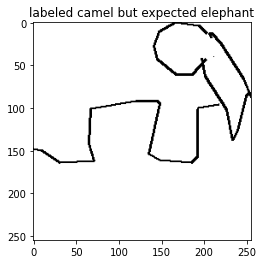

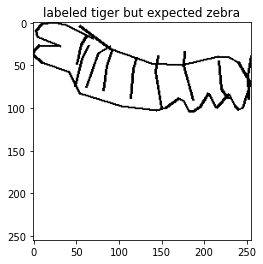

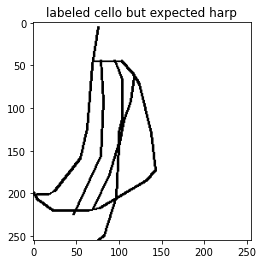

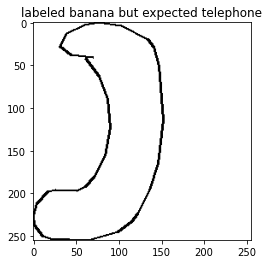

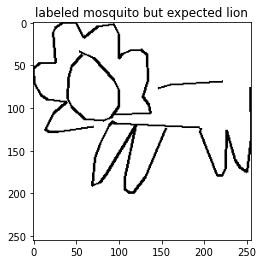

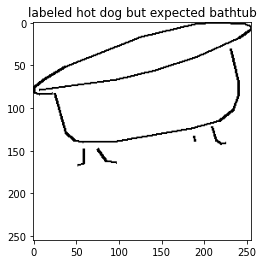

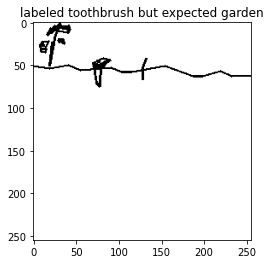

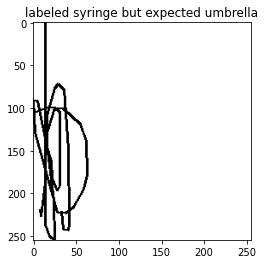

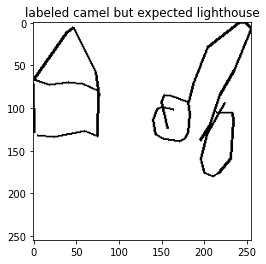

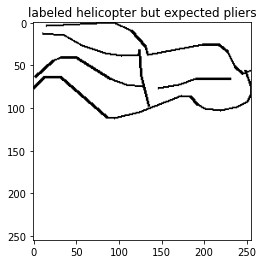

In [ ]:
small_for_graphs = SketchDataSet(valid_cnn[:20], valid_labels_cnn[:20], classes, transform=transform)
gen_faulty(model, list(classes.keys()), small_for_graphs)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, f1_score
import seaborn as sn
import pandas as pd

def make_confusion_matrix(model, dataloader):
  model.eval()
  true = []
  preds = []
  with torch.no_grad():
      for (input_batch, expected_out) in tq.tqdm(dataloader, position=0, leave=True, desc="Making Confusion Matrix"):
            output = model(input_batch.to(get_device()))
            labels = torch.flatten(expected_out).to(get_device())
            predicted = torch.max(output.data, 1)[1].to(get_device())
            true.append(labels.cpu().numpy())
            preds.append(predicted.cpu().numpy())
  t = np.array(true).flatten()
  print(t)
  p = np.array(preds).flatten()
  cm = confusion_matrix(t, p)
  return cm, t, p


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cnn_figs_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "cnnfigs")
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (40,40))
    sn.heatmap(df_cm, annot=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(cnn_figs_path+title+ ".png")
    return

In [ ]:
def make_class_df(c, cm, t, p):
  class_accuracy=cm.diagonal()/cm.sum(1)
  classes_list = list(c.keys())
  pr, re, fb, _ = precision_recall_fscore_support(t,p)
  dic = {"Classes":classes_list, "Accuracy": class_accuracy, "Precision": pr, "Recall": re, "Fbeta": fb}
  return pd.DataFrame(data=dic)

In [ ]:
cm_dataset   = SketchDataSetStream("/255/test_data.p", "/255/test_label.p", classes, transform=transform)
cm_dataloader   = DataLoader(cm_dataset, batch_size=BATCH_SIZE)

model = SketchNet(len(classes)).to(get_device())
model.load_state_dict(torch.load(flattened_data_path + "/140classes_normalized_larger160.pt"))

In [ ]:
cm, true_test, pred_test = make_confusion_matrix(model, cm_dataloader)


[  0   0   0 ... 139 139 139]


In [ ]:
df = make_class_df(classes, cm, true_test, pred_test)
df.to_csv(os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "cnnfigs", "final_140.csv"))
df

,Classes,Accuracy,Precision,Recall,Fbeta
0,The Eiffel Tower,0.669474,0.493789,0.669474,0.568365
1,The Mona Lisa,0.568765,0.539823,0.568765,0.553916
2,angel,0.440299,0.383740,0.440299,0.410078
3,ant,0.123570,0.109312,0.123570,0.116004
4,apple,0.739962,0.638614,0.739962,0.685562
...,...,...,...,...,...
135,whale,0.072115,0.206897,0.072115,0.106952
136,windmill,0.481481,0.375451,0.481481,0.421907
137,wine bottle,0.671875,0.625780,0.671875,0.648009
138,zebra,0.378906,0.331624,0.378906,0.353692


In [ ]:
print('Macro')
print("Precision:", precision_score(true_test, pred_test, average="macro"))
print("Recall", recall_score(true_test, pred_test, average="macro"))
print("F1", f1_score(true_test, pred_test, average="macro"))

print("Micro")
print("Precision:", precision_score(true_test, pred_test, average="micro"))
print("Recall", recall_score(true_test, pred_test, average="micro"))
print("F1", f1_score(true_test, pred_test, average="micro"))


Macro
Precision: 0.40907198555678875
Recall 0.4174847558642129
F1 0.4078164538328927
Micro
Precision: 0.424616599007668
Recall 0.424616599007668
F1 0.424616599007668


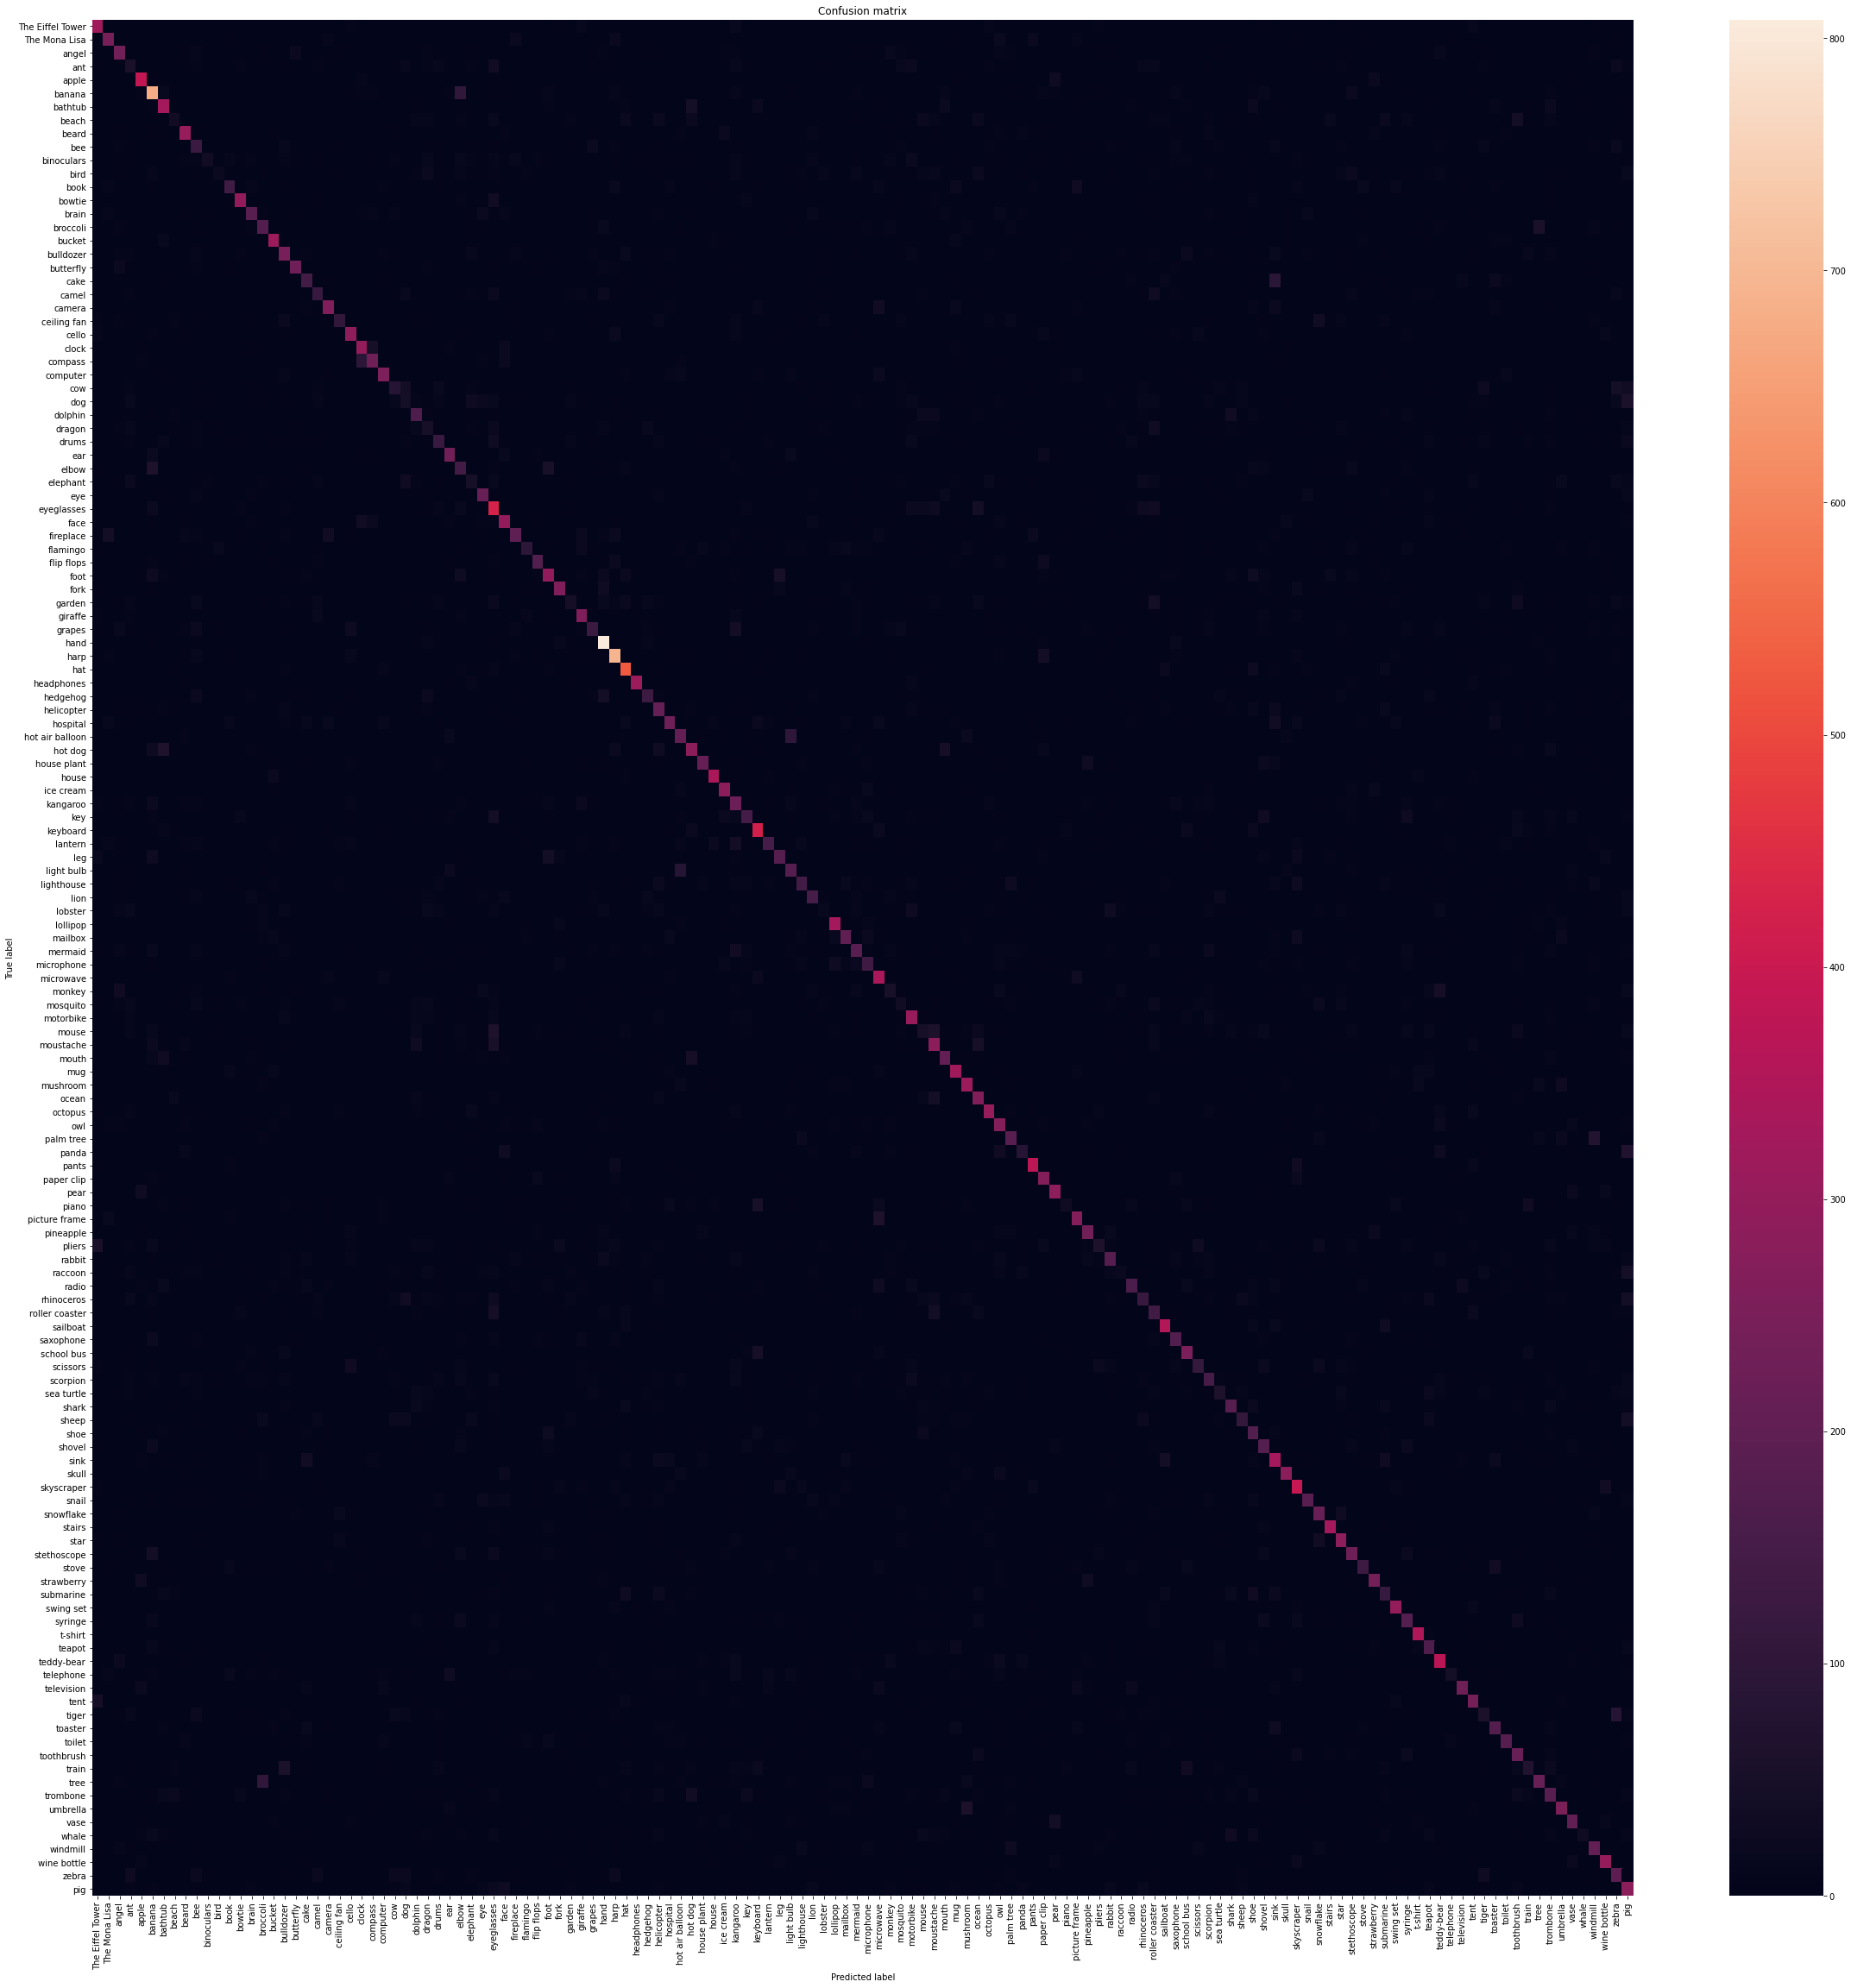

In [ ]:
plot_confusion_matrix(cm, list(classes.keys()))

In [ ]:
cm_pandas = pd.DataFrame(cm)
cm_pandas.columns = list(classes.keys())
cm_pandas.index = list(classes.keys())
cm_pandas.to_csv(os.path.join(os.getcwd(), "drive", "My Drive", "CS 4701 Prac", "cnnfigs", "confusion.csv"))
cm_pandas

,The Eiffel Tower,The Mona Lisa,angel,ant,apple,banana,bathtub,beach,beard,bee,binoculars,bird,book,bowtie,brain,broccoli,bucket,bulldozer,butterfly,cake,camel,camera,ceiling fan,cello,clock,compass,computer,cow,dog,dolphin,dragon,drums,ear,elbow,elephant,eye,eyeglasses,face,fireplace,flamingo,...,scissors,scorpion,sea turtle,shark,sheep,shoe,shovel,sink,skull,skyscraper,snail,snowflake,stairs,star,stethoscope,stove,strawberry,submarine,swing set,syringe,t-shirt,teapot,teddy-bear,telephone,television,tent,tiger,toaster,toilet,toothbrush,train,tree,trombone,umbrella,vase,whale,windmill,wine bottle,zebra,pig
The Eiffel Tower,318,0,0,2,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,3,9,0,0,1,0,0,2,0,1,0,1,0,0,0,0,2,0,...,1,1,0,0,0,0,4,3,0,0,0,3,3,5,1,0,0,1,0,2,0,0,0,1,0,14,0,0,0,0,0,0,0,0,0,0,6,3,0,0
The Mona Lisa,1,244,0,2,0,0,0,0,2,0,1,0,5,0,2,1,0,0,0,0,0,10,0,1,0,1,1,0,1,0,0,0,0,0,2,0,0,1,22,0,...,0,0,2,0,0,0,1,1,1,4,0,0,1,0,0,4,1,0,1,0,0,0,3,4,0,1,0,2,0,0,0,0,1,0,0,0,1,0,6,1
angel,1,0,236,2,0,0,0,0,5,11,0,1,1,3,0,4,0,0,23,0,3,0,6,1,0,0,0,1,2,0,8,1,2,0,4,2,1,0,3,0,...,1,1,4,0,0,2,1,1,0,0,1,3,0,6,1,1,3,1,0,1,3,5,14,0,2,0,4,3,0,0,0,1,1,0,1,0,8,0,1,2
ant,5,0,3,54,0,2,1,0,2,8,2,1,1,9,3,2,0,6,1,0,8,0,3,1,0,0,0,5,15,1,9,13,0,3,8,1,37,0,0,3,...,2,6,3,0,3,1,0,0,0,1,0,5,2,8,2,0,0,2,1,1,0,0,1,1,0,2,8,0,1,3,0,0,1,2,0,0,1,0,19,8
apple,0,0,0,0,387,4,0,0,2,0,0,0,1,0,0,0,0,0,3,0,0,0,0,1,12,2,0,0,0,0,0,0,0,0,0,0,6,0,0,0,...,0,0,0,0,1,5,2,3,0,0,0,0,1,0,3,0,21,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whale,1,1,1,2,7,17,8,3,0,1,1,2,0,1,1,0,0,4,0,6,1,0,1,1,3,1,0,0,0,5,9,1,0,7,1,3,15,0,0,0,...,0,6,2,32,2,21,1,3,0,0,4,2,0,3,1,0,3,11,0,2,0,13,1,0,0,3,1,1,1,5,3,1,10,1,0,30,0,0,0,11
windmill,4,0,10,4,0,0,0,0,0,4,0,3,1,0,0,2,0,1,0,0,1,0,2,0,0,0,1,2,0,0,3,1,0,0,1,0,1,0,2,3,...,13,1,0,0,1,0,1,2,0,0,0,15,0,4,0,1,1,0,0,2,0,1,4,0,1,1,0,1,0,0,0,2,0,0,0,0,208,0,1,0
wine bottle,3,0,0,0,12,3,1,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,1,3,0,0,0,0,0,0,0,2,1,0,0,0,2,0,0,0,...,0,0,0,0,0,1,4,1,0,19,0,0,0,0,1,0,0,0,3,2,0,0,0,1,0,4,0,0,3,0,0,0,0,0,20,0,0,301,0,0
zebra,1,1,3,26,0,0,0,1,0,24,4,0,0,2,1,1,0,4,0,0,19,0,0,0,0,0,0,20,22,1,1,9,0,0,7,2,1,0,5,2,...,2,0,3,0,8,0,1,0,0,1,0,0,0,0,0,0,1,0,4,1,0,2,0,0,1,0,31,0,0,0,0,1,3,0,0,0,4,0,194,5
